In [1]:
!pip install --quiet scikit-learn sentence_transformers pandas wordcloud


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import warnings

warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import sklearn
import nltk
import re
import numpy as np

from matplotlib import pyplot as plt
from nltk import tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from wordcloud import WordCloud, STOPWORDS

In [172]:
train_df = pd.read_csv('datasets/train_extended.csv')

In [173]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ChannelName       587 non-null    object 
 1   ChannelId         587 non-null    int64  
 2   MessageId         587 non-null    int64  
 3   Date              587 non-null    object 
 4   EditDate          573 non-null    object 
 5   Content           587 non-null    object 
 6   Suspicious_Level  587 non-null    int64  
 7   Sensitive Topic   587 non-null    object 
 8   num_sensitive     587 non-null    int64  
 9   Sentiment         587 non-null    object 
 10  Sentiment_Score   587 non-null    float64
 11  Emotion           587 non-null    object 
 12  Emotion_Score     587 non-null    float64
 13  Dangerous         587 non-null    bool   
 14  Dangerous_Score   587 non-null    float64
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 64.9+ KB


In [174]:
test_df = pd.read_csv('datasets/test_extended.csv')

In [175]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ChannelName      1171 non-null   object 
 1   ChannelId        1171 non-null   int64  
 2   MessageId        1171 non-null   int64  
 3   Date             1171 non-null   object 
 4   EditDate         884 non-null    object 
 5   Content          1171 non-null   object 
 6   Sensitive Topic  1171 non-null   object 
 7   Sentiment        1171 non-null   object 
 8   Sentiment_Score  1171 non-null   float64
 9   Emotion          1171 non-null   object 
 10  Emotion_Score    1171 non-null   float64
 11  Dangerous        1171 non-null   bool   
 12  Dangerous_Score  1171 non-null   float64
 13  num_sensitive    1171 non-null   int64  
dtypes: bool(1), float64(3), int64(3), object(7)
memory usage: 120.2+ KB


In [176]:
train_df.head(n=3)

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Sensitive Topic,num_sensitive,Sentiment,Sentiment_Score,Emotion,Emotion_Score,Dangerous,Dangerous_Score
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,"weapons,politics",2,neutral,0.948454,neutral,0.745498,False,0.913780
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"politics,racism",2,neutral,0.498936,gratitude,0.868692,False,0.948626
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881,gratitude,0.769272,False,0.949768


### Preprocessing

In [7]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

[nltk_data] Downloading package punkt to /Users/danorel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [198]:
train_df["Content_processed"] = train_df["Content"].apply(process_text)

In [199]:
train_df.head(n=3)

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Sensitive Topic,num_sensitive,Sentiment,Sentiment_Score,Emotion,Emotion_Score,Dangerous,Dangerous_Score,Content_processed
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,"weapons,politics",2,neutral,0.948454,neutral,0.745498,False,0.913780,Работа наших бойцов к югу от Артемовска. Работ...
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"politics,racism",2,neutral,0.498936,gratitude,0.868692,False,0.948626,"Анкара нарушила договорённости, отпустив глава..."
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881,gratitude,0.769272,False,0.949768,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! Пополните ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danorel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


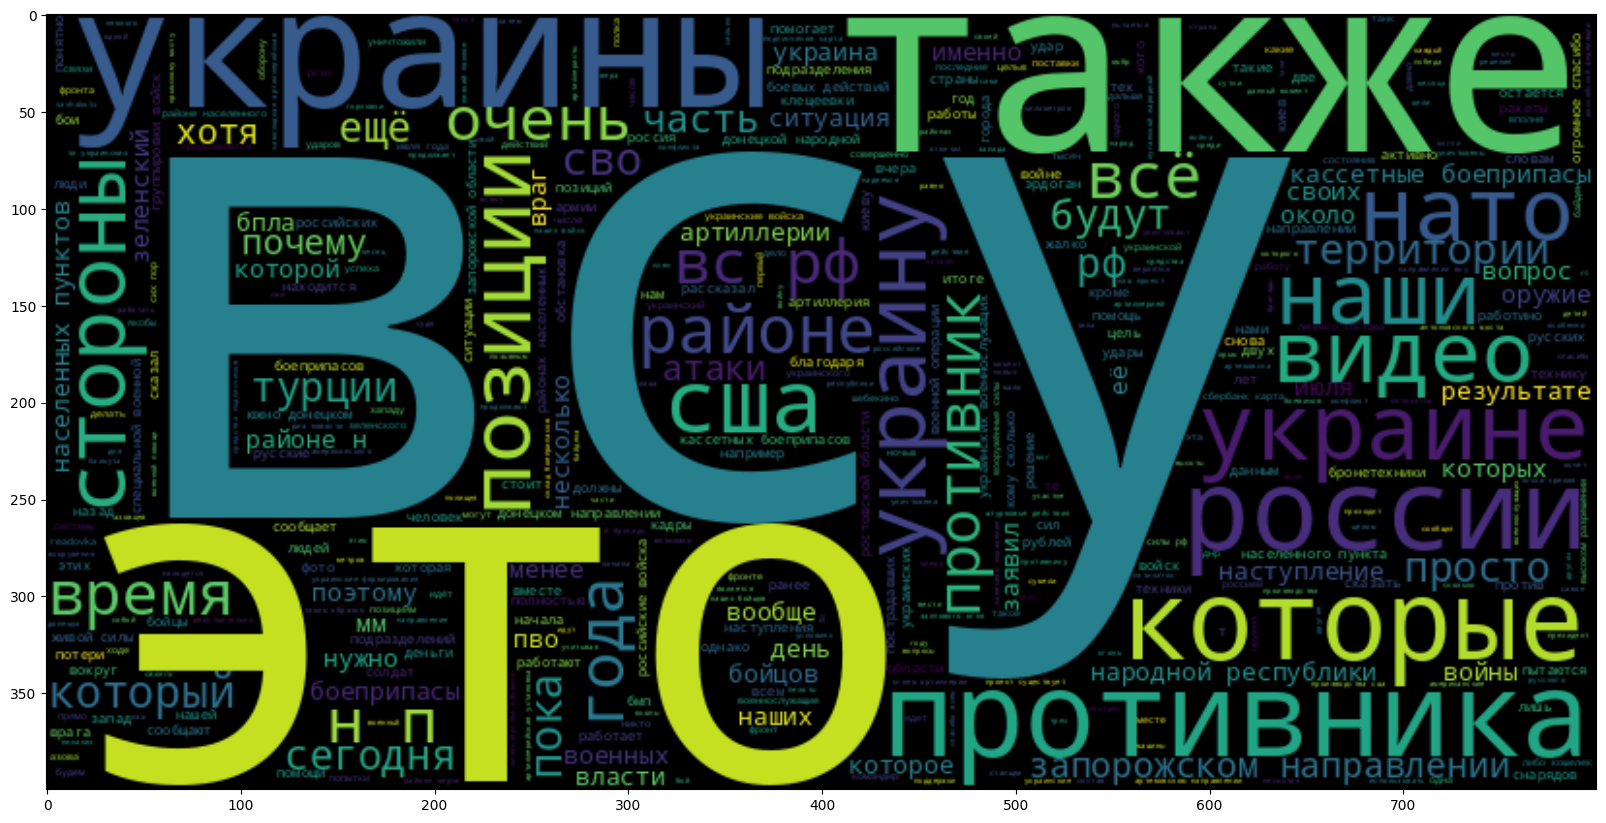

In [200]:
nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# ua_stopwords = stopwords.words("ukrainian")

plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords).generate(" ".join(train_df["Content_processed"].apply(lambda x: str(x).lower())))
plt.imshow(wc, interpolation = 'bilinear')

In [201]:
sent_emb_model = SentenceTransformer("DeepPavlov/rubert-base-cased", device="cpu")

No sentence-transformers model found with name /Users/danorel/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/danorel/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly iden

In [202]:
train_news_embeddings, train_labels = (
    sent_emb_model.encode(
        train_df["Content_processed"].to_list(), 
        show_progress_bar=True, 
        batch_size=100
    ), 
    train_df["Suspicious_Level"]
)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [203]:
len(train_news_embeddings[0])

768

In [246]:
train_df.head()

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Sensitive Topic,num_sensitive,Sentiment,Sentiment_Score,Emotion,Emotion_Score,Dangerous,Dangerous_Score,Content_processed
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,"weapons,politics",2,neutral,0.948454,neutral,0.745498,False,0.913780,Работа наших бойцов к югу от Артемовска. Работ...
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"politics,racism",2,neutral,0.498936,gratitude,0.868692,False,0.948626,"Анкара нарушила договорённости, отпустив глава..."
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881,gratitude,0.769272,False,0.949768,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! Пополните ...
3,boris_rozhin,1101806611,91573,2023-07-08 02:07:05,2023-07-08 02:07:19,МТ-ЛБ с 32-зарядной авиационной пусковой устан...,1,weapons,1,neutral,0.973560,neutral,0.906539,False,0.940683,МТ-ЛБ с 32-зарядной авиационной пусковой устан...
4,swodki,1144180066,280695,2023-07-09 07:01:49,2023-07-09 07:05:08,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,none,0,neutral,0.788881,gratitude,0.769272,False,0.949768,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! Пополните ...


In [231]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

def process_x(df, news_embeddings, test: bool = False):
    mms = MinMaxScaler()
    le = LabelEncoder()
    
    X = df.drop([
        'Content', 
        'ChannelId', 
        'MessageId', 
        'Date', 
        'EditDate',
        'ChannelName',
        'Content_processed'
    ], axis=1)  # Adjust 'target_column' to the actual column name containing your labels
    
    if not test:
        X = X.drop('Suspicious_Level', axis=1)

    X['Sentiment'] = le.fit_transform(X['Sentiment'])
    X['Sentiment'] = mms.fit_transform(X['Sentiment'].values.reshape(-1, 1))

    X['Emotion'] = le.fit_transform(X['Emotion'])
    X['Emotion'] = mms.fit_transform(X['Emotion'].values.reshape(-1, 1))

    X['Dangerous'] = le.fit_transform(X['Dangerous'])
    X['Dangerous'] = mms.fit_transform(X['Dangerous'].values.reshape(-1, 1))

    X['Sensitive Topic'] = le.fit_transform(X['Sensitive Topic'])
    X['Sensitive Topic'] = mms.fit_transform(X['Sensitive Topic'].values.reshape(-1, 1))

    return pd.DataFrame.from_records(np.concatenate((X, news_embeddings), axis=1))

### Visualizations

In [205]:
train_tsne_news_embeddings = TSNE(random_state=42).fit_transform(train_news_embeddings)

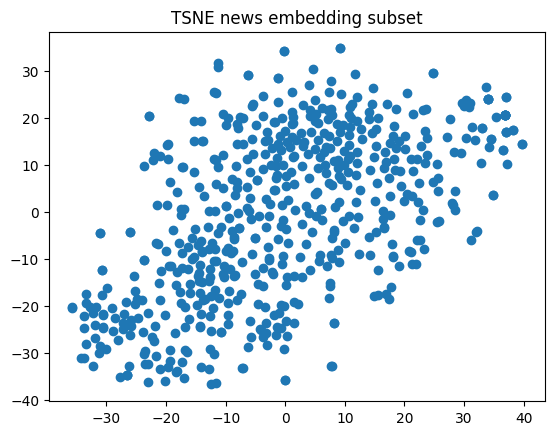

In [206]:
plt.title("TSNE news embedding subset")
plt.scatter(train_tsne_news_embeddings[:,0], train_tsne_news_embeddings[:,1])
plt.show()

In [207]:
k_means = KMeans(
    n_clusters=3, 
    random_state=42, 
    init="k-means++"
)

train_tsne_kmeans_clusts_news_embeddings = k_means.fit_predict(train_tsne_news_embeddings)

/Users/danorel/.pyenv/versions/disinformation_3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



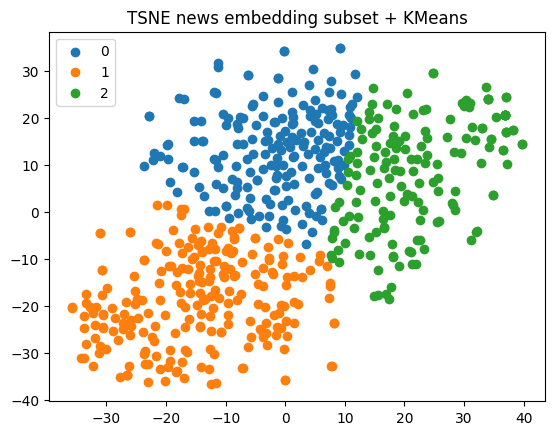

In [208]:
plt.title("TSNE news embedding subset + KMeans")
for clust in np.arange(3):
    plt.scatter(
        train_tsne_news_embeddings[train_tsne_kmeans_clusts_news_embeddings == clust, 0],
        train_tsne_news_embeddings[train_tsne_kmeans_clusts_news_embeddings == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [209]:
train_df[train_tsne_kmeans_clusts_news_embeddings == 2].Content.to_list()[:5]

['Анкара нарушила договорённости, отпустив главарей "Азова" (запрещен в РФ) на Украину, заявил официальный представитель Кремля Дмитрий Песков.\n\nПо его словам, турецкие власти не сообщали Москве о своем решении.\n\nПодписаться на @truekpru',
 'ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополните\xa0\xa0 СБЕРБАНК-карту: 4276160925483621\nлибо \n‼️Кошелек Ю-Мани: 410012479564046\n\n\nКому сколько не жалко. Хоть по 10 руб.\n\nОгромное спасибо и низкий поклон всем кто помогает!',
 'ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополните\xa0\xa0 СБЕРБАНК-карту: 4276160925483621\nлибо \n‼️Кошелек Ю-Мани: 410012479564046\n\n\nКому сколько не жалко. Хоть по 10 руб.\n\nОгромное спасибо и низкий поклон всем кто помогает!',
 'Вчера на эфире "60 минут" поговорили о том, как живётся нынче банкиру Фридману и отчего он поверил англо-саксам.\n\nКак нам вернуть домой русских, и нужно ли возвращать всех.\n\nИ о том, есть ли какая-то связь между тем, что одним яхту негде припарковать, а у бойцов лодок на Днепре

### Cross-validation

In [210]:
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
import numpy as np

In [211]:
tsne = TSNE(n_components=2, random_state=42)

train_tsne_news_embeddings = tsne.fit_transform(train_news_embeddings)

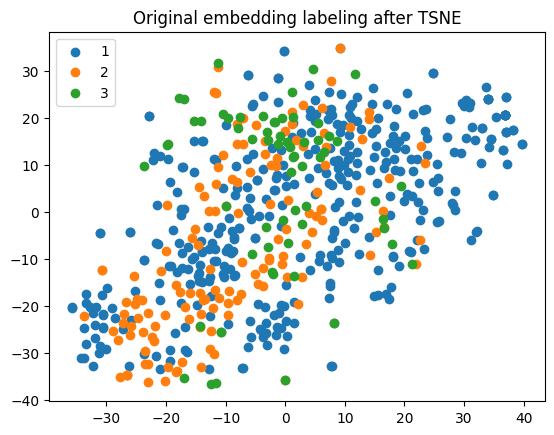

In [212]:
plt.title("Original embedding labeling after TSNE")
for clust in np.arange(1, 4):
    cluster_indices = train_labels.loc[train_labels == clust].index
    label = train_labels[train_df['Suspicious_Level'] == clust]
    plt.scatter(
        train_tsne_news_embeddings[cluster_indices, 0],
        train_tsne_news_embeddings[cluster_indices, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

#### SVM only

In [213]:
# Number of folds (K)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a counter for the fold number
fold_number = 1

# Labels (y)
X = process_x(train_df, train_news_embeddings)
y = train_df['Suspicious_Level']

f1_score_folds = []

for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Initialize SVM model
    svm_model = SVC(kernel='poly', random_state=42)
    
    # Train SVM model
    svm_model.fit(X_train, y_train)
    
    # Predict using the trained SVM model
    y_pred = svm_model.predict(X_val).reshape(-1, 1)
    
    # Evaluate the model (e.g., using f1 score)
    f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
    f1_score_folds.append(f1_score)
    
    # Print the fold number and f1 score
    print(f"Fold {fold_number} - F1 Score: {f1_score}")
    
    # Compute confusion matrix
    print(sklearn.metrics.classification_report(y_pred, y_val))

    # Increment the fold number
    fold_number += 1

f1_mean_score = np.mean(f1_score_folds)
print(f"F1 Score: {f1_mean_score}")

Fold 1 - F1 Score: 0.5161632538681719
              precision    recall  f1-score   support

           1       1.00      0.73      0.84       106
           2       0.39      1.00      0.56        11
           3       0.08      1.00      0.14         1

    accuracy                           0.75       118
   macro avg       0.49      0.91      0.52       118
weighted avg       0.94      0.75      0.81       118

Fold 2 - F1 Score: 0.4684880722114764
              precision    recall  f1-score   support

           1       0.97      0.76      0.85        99
           2       0.46      0.68      0.55        19
           3       0.00      0.00      0.00         0

    accuracy                           0.75       118
   macro avg       0.48      0.48      0.47       118
weighted avg       0.89      0.75      0.80       118

Fold 3 - F1 Score: 0.35370370370370363
              precision    recall  f1-score   support

           1       0.96      0.70      0.81       104
           2  

/Users/danorel/.pyenv/versions/disinformation_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/danorel/.pyenv/versions/disinformation_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/danorel/.pyenv/versions/disinformation_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Fold 4 - F1 Score: 0.5362745098039216
              precision    recall  f1-score   support

           1       0.96      0.78      0.86        94
           2       0.43      0.60      0.50        20
           3       0.15      0.67      0.25         3

    accuracy                           0.74       117
   macro avg       0.51      0.68      0.54       117
weighted avg       0.85      0.74      0.78       117

Fold 5 - F1 Score: 0.42297551789077215
              precision    recall  f1-score   support

           1       0.92      0.71      0.80       100
           2       0.26      0.47      0.33        15
           3       0.08      0.50      0.13         2

    accuracy                           0.68       117
   macro avg       0.42      0.56      0.42       117
weighted avg       0.82      0.68      0.73       117

F1 Score: 0.45952101149560914


### Fine-tuning

In [214]:
!pip install --quiet optuna plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [215]:
import optuna

from optuna.pruners import SuccessiveHalvingPruner

In [216]:
def tune_svc_only():
    
    def objective(trial):
        kernel = "poly"
        C = trial.suggest_float('C', 1e-5, 1e5, log=True)
        decision_function_shape = trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr'])
        degree = trial.suggest_int('degree', 2, 10, log=False, step=1)
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

        # Number of folds (K)
        num_folds = 5
        skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

        # Initialize a counter for the fold number
        fold_number = 1

        # Labels (y)
        X = process_x(train_df, train_news_embeddings)
        y = train_df['Suspicious_Level']

        f1_score_folds = []
        misclassified_samples = []

        for fold, (train_index, val_index) in enumerate(skf.split(X_combined, y)):
            # Split the data into training and validation sets
            X_train, X_val = X_combined.iloc[train_index], X_combined.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Initialize SVM model
            svm_model = SVC(
                C=C, 
                kernel=kernel, 
                gamma=gamma,
                degree=degree, 
                decision_function_shape=decision_function_shape,
                class_weight="balanced", 
                random_state=42
            )

            # Train SVM model
            svm_model.fit(X_train, y_train)

            # Predict using the trained SVM model
            y_pred = svm_model.predict(X_val).reshape(-1, 1)

            # Evaluate the model (e.g., using f1 score)
            f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
            f1_score_folds.append(f1_score)

            trial.report(f1_score, fold)
            if trial.should_prune():
                raise optuna.TrialPruned()

            # Increment the fold number
            fold_number += 1

        f1_mean_score = np.mean(f1_score_folds)

        return f1_mean_score
    
    # 1. Pruner
    pruner = SuccessiveHalvingPruner(min_resource=1, reduction_factor=2, min_early_stopping_rate=0)

    # 2. Create a Study Object
    study = optuna.create_study(pruner=pruner, direction='maximize')

    # 3. Run the Optimization Process
    study.optimize(objective, n_trials=150)  # You can adjust the number of trials
    
    # Print best hyperparameters and corresponding F1 score
    print("Best trial:")
    trial = study.best_trial
    print(f"Value: {trial.value}")
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study, trial.params

In [217]:
svc_only_study, svc_only_params = tune_svc_only()

[I 2023-11-18 19:06:03,862] A new study created in memory with name: no-name-53bae3bb-4489-4ff5-8691-6ed5ba7a2899
[I 2023-11-18 19:06:04,323] Trial 0 finished with value: 0.14529914529914528 and parameters: {'C': 3.397241021669183, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto'}. Best is trial 0 with value: 0.14529914529914528.
[I 2023-11-18 19:06:04,472] Trial 1 pruned. 
[I 2023-11-18 19:06:04,825] Trial 2 finished with value: 0.5529713514300056 and parameters: {'C': 0.20380679917348402, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 'scale'}. Best is trial 2 with value: 0.5529713514300056.
[I 2023-11-18 19:06:05,038] Trial 3 pruned. 
[I 2023-11-18 19:06:05,376] Trial 4 pruned. 
[I 2023-11-18 19:06:05,546] Trial 5 pruned. 
[I 2023-11-18 19:06:05,736] Trial 6 pruned. 
[I 2023-11-18 19:06:06,008] Trial 7 pruned. 
[I 2023-11-18 19:06:06,222] Trial 8 pruned. 
[I 2023-11-18 19:06:06,548] Trial 9 finished with value: 0.6223325621569726 and parameters: {'C': 40.51264

Best trial:
Value: 0.6526842340556351
Params: 
    C: 3.759654889813155
    decision_function_shape: ovo
    degree: 3
    gamma: scale


#### Visualization

In [218]:
!pip install --quiet plotly ipykernel nbformat

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [219]:
import optuna.visualization as vis

In [220]:
def visualize(study, params):
    optimization_history_plot = vis.plot_optimization_history(study)
    optimization_history_plot.show()
    
    param_importance_plot = vis.plot_param_importances(study)
    param_importance_plot.show()
    
    contour_plot = vis.plot_contour(study, params=params)
    contour_plot.show()

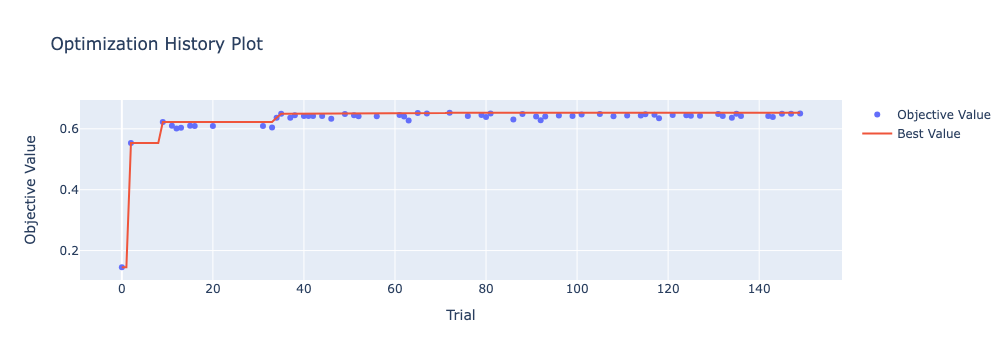

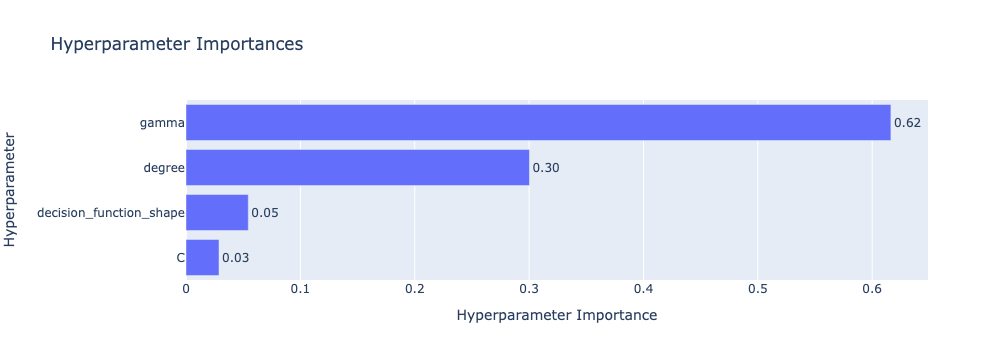

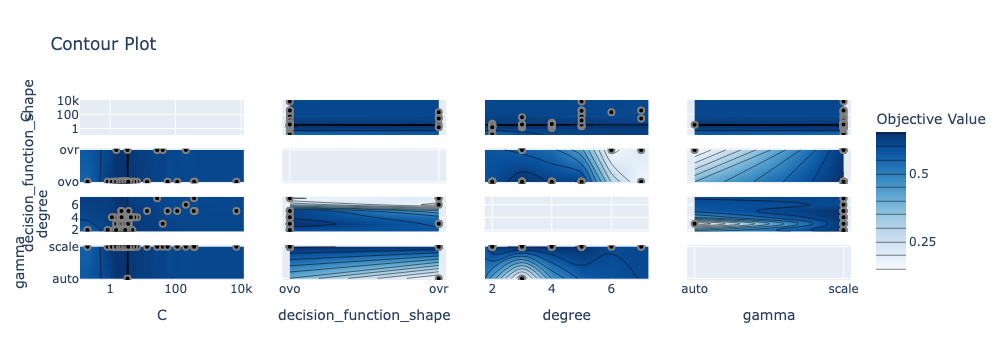

In [221]:
visualize(svc_only_study, ["C", "degree", "gamma", "decision_function_shape"])

### Submission

In [223]:
test_df["Content_processed"] = test_df["Content"].apply(process_text)

test_news_embeddings = sent_emb_model.encode(
    test_df["Content_processed"].to_list(), 
    show_progress_bar=True, 
    batch_size=100
)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

KeyError: "['Suspicious_Level'] not found in axis"

In [232]:
X_test = process_x(test_df, test_news_embeddings, test=True)

In [240]:
X_train = process_x(train_df, train_news_embeddings)
y_train = train_df['Suspicious_Level']

svm_model = SVC(**svc_only_params, kernel="poly", class_weight="balanced", random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_train).reshape(-1, 1)

print(sklearn.metrics.classification_report(y_pred, y_train))

test_df['Suspicious_Level'] = svm_model.predict(X_test).reshape(-1, 1)

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       372
           2       0.92      0.96      0.94       134
           3       1.00      0.80      0.89        81

    accuracy                           0.96       587
   macro avg       0.96      0.92      0.94       587
weighted avg       0.96      0.96      0.96       587



In [243]:
test_df[['MessageId', 'Suspicious_Level']].to_csv('danya_submission.csv', index=False)

In [244]:
test_df.head(n=3)

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Sensitive Topic,Sentiment,Sentiment_Score,Emotion,Emotion_Score,Dangerous,Dangerous_Score,num_sensitive,Content_processed,Suspicious_Level
0,ukraina_ru,1175084215,168641,2023-09-11 16:57:36,2023-09-11 16:57:50,"⚡️Администрация Байдена близка к тому, чтобы о...","weapons,politics",negative,0.608944,neutral,0.513087,False,0.954423,2,"Администрация Байдена близка к тому, чтобы одо...",2
1,bear007,1505866568,36569,2023-09-11 14:52:01,2023-09-11 14:52:12,РИА Новости публикует первые кадры с места гиб...,"offline_crime,politics",neutral,0.955055,neutral,0.714759,False,0.948009,2,РИА Новости публикует первые кадры с места гиб...,1
2,zakharprilepin,1217080686,19697,2023-09-11 08:26:09,NaN,Вице-спикер Госдумы Петр Толстой - о сроках ок...,"terrorism,politics",negative,0.850013,admiration,0.257196,False,0.954249,2,Вице-спикер Госдумы Петр Толстой - о сроках ок...,1
